<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Importation-des-librairies" data-toc-modified-id="Importation-des-librairies-0.0.0.1"><span class="toc-item-num">0.0.0.1&nbsp;&nbsp;</span>Importation des librairies</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature engineering</a></span><ul class="toc-item"><li><span><a href="#Preprocessing-functions" data-toc-modified-id="Preprocessing-functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preprocessing functions</a></span><ul class="toc-item"><li><span><a href="#Application-Train-Test" data-toc-modified-id="Application-Train-Test-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Application Train Test</a></span></li><li><span><a href="#Previous-Applications" data-toc-modified-id="Previous-Applications-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Previous Applications</a></span></li><li><span><a href="#Bureau-and-Bureau-Balances" data-toc-modified-id="Bureau-and-Bureau-Balances-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Bureau and Bureau Balances</a></span></li><li><span><a href="#POS-Cash-Balance" data-toc-modified-id="POS-Cash-Balance-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>POS Cash Balance</a></span></li><li><span><a href="#Installments-Payments" data-toc-modified-id="Installments-Payments-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Installments Payments</a></span></li><li><span><a href="#Credit-Card-Balance" data-toc-modified-id="Credit-Card-Balance-1.1.6"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>Credit Card Balance</a></span></li></ul></li><li><span><a href="#Batch-preprocessing" data-toc-modified-id="Batch-preprocessing-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Batch preprocessing</a></span></li><li><span><a href="#Missing-data" data-toc-modified-id="Missing-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Missing data</a></span></li></ul></li><li><span><a href="#Readable-file-creation-for-Dashboard" data-toc-modified-id="Readable-file-creation-for-Dashboard-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Readable file creation for Dashboard</a></span></li><li><span><a href="#Data-exploration" data-toc-modified-id="Data-exploration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data exploration</a></span><ul class="toc-item"><li><span><a href="#Used-Functions" data-toc-modified-id="Used-Functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Used Functions</a></span></li></ul></li><li><span><a href="#Modelisation" data-toc-modified-id="Modelisation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modelisation</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#RandomForest-Classifier" data-toc-modified-id="RandomForest-Classifier-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>RandomForest Classifier</a></span></li><li><span><a href="#LightGBM-Classifier" data-toc-modified-id="LightGBM-Classifier-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LightGBM Classifier</a></span></li></ul></li><li><span><a href="#Features-Selection-and-final-export" data-toc-modified-id="Features-Selection-and-final-export-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Features Selection and final export</a></span></li><li><span><a href="#Interprétation-LIME" data-toc-modified-id="Interprétation-LIME-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Interprétation LIME</a></span></li><li><span><a href="#Interprétation-SHAP" data-toc-modified-id="Interprétation-SHAP-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Interprétation SHAP</a></span></li><li><span><a href="#Client-Neighbors" data-toc-modified-id="Client-Neighbors-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Client Neighbors</a></span></li></ul></div>

#### Importation des librairies

In [1]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
%matplotlib inline


pd.set_option('display.max_columns', 800)
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None  # default='warn'

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Feature engineering

In [4]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

## Preprocessing functions

### Application Train Test

In [5]:
# Preprocess application_train.csv and application_test.csv
# - Divide or subtract important features to get rates (like annuity and income)
def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = pd.read_csv('data/input/application_train.csv', nrows=num_rows)
    test_df = pd.read_csv(
        'data/input/application_test.csv', nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

### Previous Applications

In [6]:
# Preprocess previous_applications.csv
# - In Previous Applications: create specific features for Approved and Refused applications
def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv(
        'data/input/previous_application.csv', nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg(
        {**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(
        ['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(
        ['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(
        ['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

### Bureau and Bureau Balances

In [7]:
# Preprocess bureau.csv and bureau_balance.csv
# - In Bureau Data: create specific features for Active credits and Closed credits
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv('data/input/bureau.csv', nrows=num_rows)
    bb = pd.read_csv('data/input/bureau_balance.csv', nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper()
                              for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg(
        {**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(
        ['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(
        ['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(
        ['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

### POS Cash Balance

In [8]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv('data/input/POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(
        ['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

### Installments Payments

In [9]:
# Preprocess installments_payments.csv
def installments_payments(num_rows: object = None, nan_as_category: object = True) -> object:
    ins = pd.read_csv(
        'data/input/installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(
        ['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

### Credit Card Balance

In [10]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv(
        'data/input/credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper()
                              for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

## Batch preprocessing

In [11]:
def preprocess_files(debug=False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

In [12]:
data = preprocess_files()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 11s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 11s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 6s
Installments payments df shape: (339587, 26)
Process installments payments - done in 17s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 12s


In [13]:
data.to_csv('data/outputs/data_preprocessed.csv', index=False)

In [14]:
data = pd.read_csv('data/outputs/data_preprocessed.csv')

## Missing data

In [15]:
# Taux de remplissage
missing = ((1 - data.isnull().mean())*100).sort_values(ascending=False)
print(missing[missing > 20])

index                                    100.000000
OCCUPATION_TYPE_Managers                 100.000000
OCCUPATION_TYPE_Private service staff    100.000000
OCCUPATION_TYPE_Realty agents            100.000000
OCCUPATION_TYPE_Sales staff              100.000000
                                            ...    
CC_AMT_DRAWINGS_ATM_CURRENT_VAR           20.124014
CC_AMT_DRAWINGS_POS_CURRENT_VAR           20.124014
CC_CNT_DRAWINGS_POS_CURRENT_VAR           20.124014
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR         20.124014
CC_AMT_PAYMENT_CURRENT_VAR                20.098751
Length: 791, dtype: float64


In [16]:
# Cleaning des colonnes de moins de 20% de remplissage
def clean_taux(df, taux):
    missing = ((1 - df.isnull().mean())*100)
    column_to_keep = missing[missing > taux]
    columns_to_delete = list(set(df.columns) - set(column_to_keep.index.tolist()))
    print("{} deleted columns with less than {}% of completeness".format(len(df.columns)-len(column_to_keep),taux))
    print("\nDeleted columns: {}".format(columns_to_delete))
    df_c = df[column_to_keep.index.tolist()]
    return df_c

data = clean_taux(data, 20)

7 deleted columns with less than 20% of completeness

Deleted columns: ['REFUSED_APP_CREDIT_PERC_VAR', 'REFUSED_RATE_DOWN_PAYMENT_MAX', 'REFUSED_AMT_DOWN_PAYMENT_MIN', 'REFUSED_RATE_DOWN_PAYMENT_MIN', 'REFUSED_AMT_DOWN_PAYMENT_MAX', 'REFUSED_AMT_DOWN_PAYMENT_MEAN', 'REFUSED_RATE_DOWN_PAYMENT_MEAN']


# Readable file creation for Dashboard

In [17]:
    # Preprocess application_train.csv and application_test.csv
    # - Divide or subtract important features to get rates (like annuity and income)
    def application_train_test(num_rows=None, nan_as_category=False):
        # Read data and merge
        df = pd.read_csv('data/input/application_train.csv', nrows=num_rows)
        test_df = pd.read_csv(
            'data/input/application_test.csv', nrows=num_rows)
        print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
        df = df.append(test_df).reset_index()
        # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
        df = df[df['CODE_GENDER'] != 'XNA']

        # Categorical features with Binary encode (0 or 1; two categories)
        #for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        #    df[bin_feature], uniques = pd.factorize(df[bin_feature])
        # Categorical features with One-Hot encode
        #df, cat_cols = one_hot_encoder(df, nan_as_category)

        # NaN values for DAYS_EMPLOYED: 365.243 -> nan
        df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

        # Some simple new features (percentages)
        df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
        df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
        df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
        df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
        df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
        del test_df
        gc.collect()
        return df

    # Preprocess previous_applications.csv
    # - In Previous Applications: create specific features for Approved and Refused applications
    def previous_applications(num_rows=None, nan_as_category=True):
        prev = pd.read_csv(
            'data/input/previous_application.csv', nrows=num_rows)
        #prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
        # Days 365.243 values -> nan
        prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
        prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
        prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
        prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
        prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
        # Add feature: value ask / value received percentage
        prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
        # Previous applications numeric features
        num_aggregations = {
            'AMT_ANNUITY': ['min', 'max', 'mean'],
            'AMT_APPLICATION': ['min', 'max', 'mean'],
            'AMT_CREDIT': ['min', 'max', 'mean'],
            'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
            'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
            'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
            'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
            'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
            'DAYS_DECISION': ['min', 'max', 'mean'],
            'CNT_PAYMENT': ['mean', 'sum'],
        }
        # Previous applications categorical features
        cat_aggregations = {}
        #for cat in cat_cols:
        #    cat_aggregations[cat] = ['mean']

        prev_agg = prev.groupby('SK_ID_CURR').agg(
            {**num_aggregations, **cat_aggregations})
        prev_agg.columns = pd.Index(
            ['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
        # Previous Applications: Approved Applications - only numerical features
        approved = prev[prev['NAME_CONTRACT_STATUS'] == 'Approved']
        approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
        approved_agg.columns = pd.Index(
            ['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
        prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
        # Previous Applications: Refused Applications - only numerical features
        refused = prev[prev['NAME_CONTRACT_STATUS'] == 'Refused']
        refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
        refused_agg.columns = pd.Index(
            ['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
        prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
        del refused, refused_agg, approved, approved_agg, prev
        gc.collect()
        return prev_agg

    # Preprocess bureau.csv and bureau_balance.csv
    # - In Bureau Data: create specific features for Active credits and Closed credits
    def bureau_and_balance(num_rows=None, nan_as_category=True):
        bureau = pd.read_csv('data/input/bureau.csv', nrows=num_rows)
        bb = pd.read_csv('data/input/bureau_balance.csv', nrows=num_rows)
        #bb, bb_cat = one_hot_encoder(bb, nan_as_category)
        #bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

        # Bureau balance: Perform aggregations and merge with bureau.csv
        bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
        #for col in bb_cat:
        #    bb_aggregations[col] = ['mean']
        bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
        bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper()
                                  for e in bb_agg.columns.tolist()])
        bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
        bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
        del bb, bb_agg
        gc.collect()

        # Bureau and bureau_balance numeric features
        num_aggregations = {
            'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
            'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
            'DAYS_CREDIT_UPDATE': ['mean'],
            'CREDIT_DAY_OVERDUE': ['max', 'mean'],
            'AMT_CREDIT_MAX_OVERDUE': ['mean'],
            'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
            'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
            'AMT_CREDIT_SUM_OVERDUE': ['mean'],
            'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
            'AMT_ANNUITY': ['max', 'mean'],
            'CNT_CREDIT_PROLONG': ['sum'],
            'MONTHS_BALANCE_MIN': ['min'],
            'MONTHS_BALANCE_MAX': ['max'],
            'MONTHS_BALANCE_SIZE': ['mean', 'sum']
        }
        # Bureau and bureau_balance categorical features
        cat_aggregations = {}
        #for cat in bureau_cat:
        #    cat_aggregations[cat] = ['mean']
        #for cat in bb_cat:
        #    cat_aggregations[cat + "_MEAN"] = ['mean']

        bureau_agg = bureau.groupby('SK_ID_CURR').agg(
            {**num_aggregations, **cat_aggregations})
        bureau_agg.columns = pd.Index(
            ['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
        # Bureau: Active credits - using only numerical aggregations
        active = bureau[bureau['CREDIT_ACTIVE'] == 'Active']
        active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
        active_agg.columns = pd.Index(
            ['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
        del active, active_agg
        gc.collect()
        # Bureau: Closed credits - using only numerical aggregations
        closed = bureau[bureau['CREDIT_ACTIVE'] == 'Closed']
        closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
        closed_agg.columns = pd.Index(
            ['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
        del closed, closed_agg, bureau
        gc.collect()
        return bureau_agg

    # Preprocess POS_CASH_balance.csv
    def pos_cash(num_rows=None, nan_as_category=True):
        pos = pd.read_csv('data/input/POS_CASH_balance.csv', nrows=num_rows)
        #pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
        # Features
        aggregations = {
            'MONTHS_BALANCE': ['max', 'mean', 'size'],
            'SK_DPD': ['max', 'mean'],
            'SK_DPD_DEF': ['max', 'mean']
        }
        #for cat in cat_cols:
        #    aggregations[cat] = ['mean']

        pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
        pos_agg.columns = pd.Index(
            ['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
        # Count pos cash accounts
        pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
        del pos
        gc.collect()
        return pos_agg

    # Preprocess installments_payments.csv
    def installments_payments(num_rows: object = None, nan_as_category: object = True) -> object:
        ins = pd.read_csv(
            'data/input/installments_payments.csv', nrows=num_rows)
        #ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
        # Percentage and difference paid in each installment (amount paid and installment value)
        ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
        ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
        # Days past due and days before due (no negative values)
        ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
        ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
        ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
        ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
        # Features: Perform aggregations
        aggregations = {
            'NUM_INSTALMENT_VERSION': ['nunique'],
            'DPD': ['max', 'mean', 'sum'],
            'DBD': ['max', 'mean', 'sum'],
            'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
            'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
            'AMT_INSTALMENT': ['max', 'mean', 'sum'],
            'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
            'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
        }
        #for cat in cat_cols:
        #    aggregations[cat] = ['mean']
        ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
        ins_agg.columns = pd.Index(
            ['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
        # Count installments accounts
        ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
        del ins
        gc.collect()
        return ins_agg

    # Preprocess credit_card_balance.csv
    def credit_card_balance(num_rows=None, nan_as_category=True):
        cc = pd.read_csv(
            'data/input/credit_card_balance.csv', nrows=num_rows)
        #cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
        # General aggregations
        cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
        cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
        cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper()
                                  for e in cc_agg.columns.tolist()])
        # Count credit card lines
        cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
        del cc
        gc.collect()
        return cc_agg

    def preprocess_files(debug=False):
        num_rows = 10000 if debug else None
        df = application_train_test(num_rows)
        with timer("Process bureau and bureau_balance"):
            bureau = bureau_and_balance(num_rows)
            print("Bureau df shape:", bureau.shape)
            df = df.join(bureau, how='left', on='SK_ID_CURR')
            del bureau
            gc.collect()
        with timer("Process previous_applications"):
            prev = previous_applications(num_rows)
            print("Previous applications df shape:", prev.shape)
            df = df.join(prev, how='left', on='SK_ID_CURR')
            del prev
            gc.collect()
        with timer("Process POS-CASH balance"):
            pos = pos_cash(num_rows)
            print("Pos-cash balance df shape:", pos.shape)
            df = df.join(pos, how='left', on='SK_ID_CURR')
            del pos
            gc.collect()
        with timer("Process installments payments"):
            ins = installments_payments(num_rows)
            print("Installments payments df shape:", ins.shape)
            df = df.join(ins, how='left', on='SK_ID_CURR')
            del ins
            gc.collect()
        with timer("Process credit card balance"):
            cc = credit_card_balance(num_rows)
            print("Credit card balance df shape:", cc.shape)
            df = df.join(cc, how='left', on='SK_ID_CURR')
            del cc
            gc.collect()
        return df

readable_data = preprocess_files()
readable_data.sort_values(by='SK_ID_CURR').head(5000).to_csv('data/outputs/readable_data_preprocessed.csv', index=False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 81)
Process bureau and bureau_balance - done in 7s
Previous applications df shape: (338857, 90)
Process previous_applications - done in 6s
Pos-cash balance df shape: (337252, 8)
Process POS-CASH balance - done in 5s
Installments payments df shape: (339587, 26)
Process installments payments - done in 17s
Credit card balance df shape: (103558, 101)
Process credit card balance - done in 13s


# Data exploration

## Used Functions

In [18]:
def barplot(data, variable, figsize=(8,5)):
    plt.figure(figsize=figsize)
    plt.title('Distribution des '+variable)
    plt.xticks(rotation=90)
    sns.countplot(data=data, y=data[variable]
                 #bins=int((data[variable].max() - data[variable].min())/1)
                  ,order = data[variable].value_counts().index
                 )
    plt.tight_layout()       
    plt.show()

In [19]:
# Pie Charts
def pie_chart(data, variable):

    # Creating autocpt arguments
    def func(pct, allvalues):
        absolute = int(pct / 100.*np.sum(allvalues))
        return "{:.1f}%\n({:d})".format(pct, absolute)

    # Creating plot
    fig, ax = plt.subplots(figsize=(7, 5))
    wedges, texts, autotexts = ax.pie(data[variable].value_counts().sort_values(ascending=False).values,
                                      autopct=lambda pct: func(
                                          pct, data[variable].value_counts().values),
                                      # labels=data.variable.value_counts().index.str.upper(),
                                      startangle=90)

    # Adding legend
    ax.legend(wedges,
              labels=[f'{l} / {s:0.1f}%' for l, s in zip(data[variable].value_counts().index,
                                                         data[variable].value_counts().values*100./data[variable].value_counts().sum())
                      ],
              title="Légende",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=12, weight="bold")
    ax.set_title("Répartition des "+variable)

    # show plot
    plt.show()

/var/folders/vx/9727mr4s5cqfgt5xykl0fgn40000gn/T/ipykernel_13718/2458971721.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(wedges,


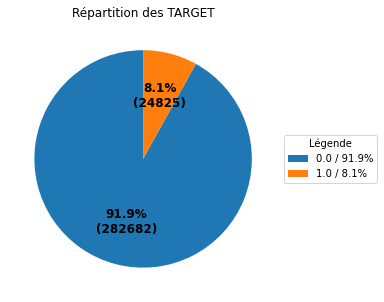

In [20]:
pie_chart(readable_data,'TARGET')

/var/folders/vx/9727mr4s5cqfgt5xykl0fgn40000gn/T/ipykernel_13718/2458971721.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(wedges,


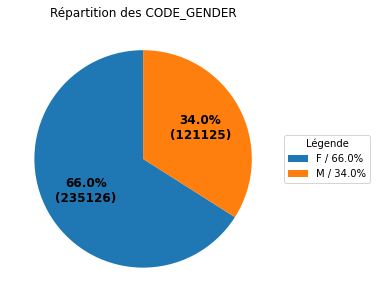

In [21]:
pie_chart(readable_data,'CODE_GENDER')

/var/folders/vx/9727mr4s5cqfgt5xykl0fgn40000gn/T/ipykernel_13718/2458971721.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(wedges,


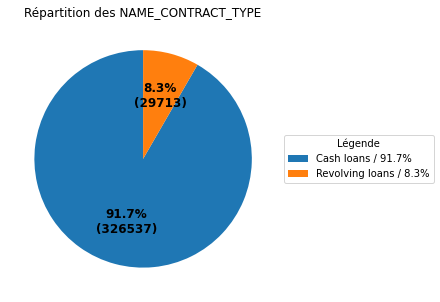

In [22]:
pie_chart(readable_data,'NAME_CONTRACT_TYPE')

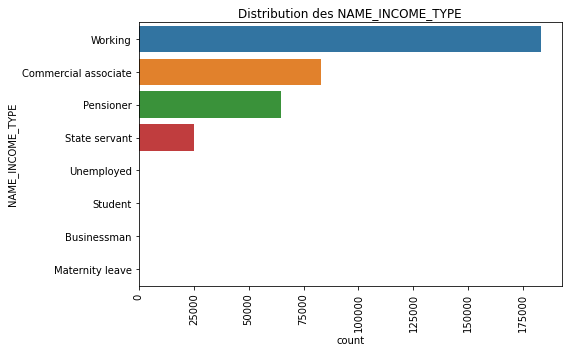

In [23]:
barplot(readable_data,'NAME_INCOME_TYPE')

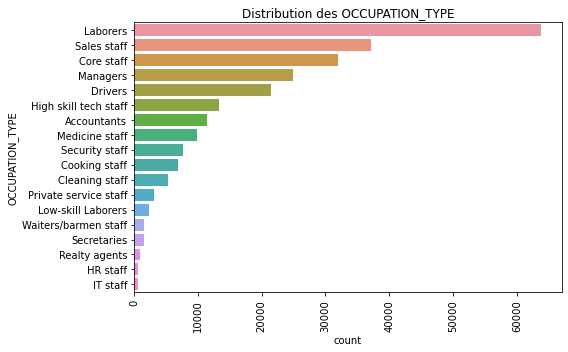

In [24]:
barplot(readable_data,'OCCUPATION_TYPE')

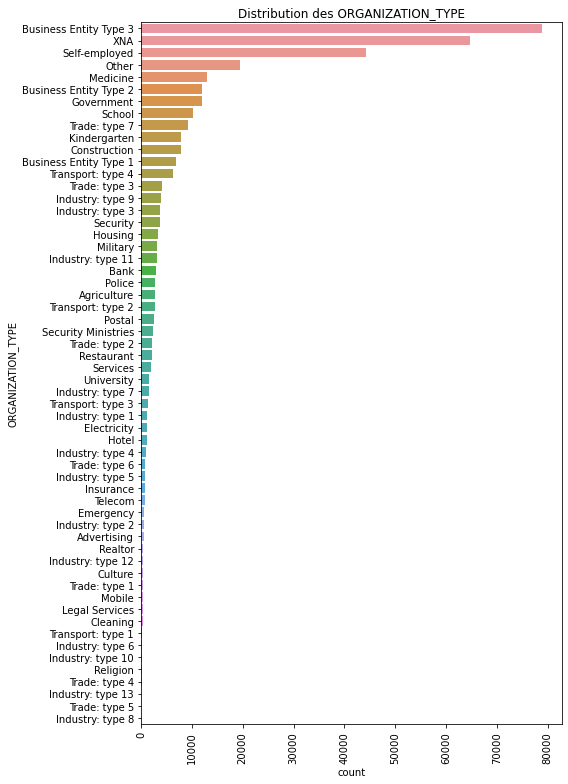

In [25]:
barplot(readable_data,'ORGANIZATION_TYPE', figsize=(8,11))

<AxesSubplot:xlabel='ACTIVE_DAYS_CREDIT_MEAN', ylabel='Count'>

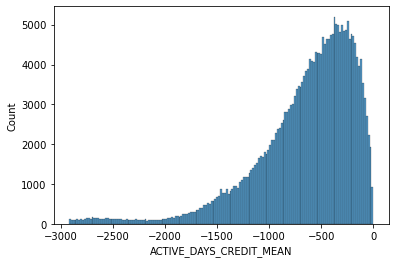

In [26]:
sns.histplot(readable_data['ACTIVE_DAYS_CREDIT_MEAN'])

<AxesSubplot:xlabel='ACTIVE_AMT_CREDIT_SUM_MEAN', ylabel='Count'>

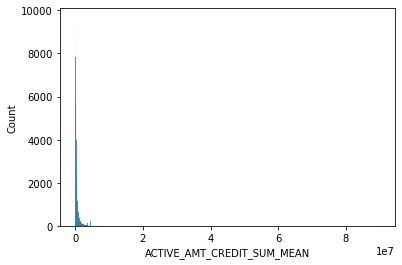

In [27]:
sns.histplot(readable_data['ACTIVE_AMT_CREDIT_SUM_MEAN'])

In [28]:
readable_data

,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MIN_MIN,BURO_MONTHS_BALANCE_MAX_MAX,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_VAR,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,ACTIVE_CREDIT_DAY_OVERDUE_MAX,ACTIVE_CREDIT_DAY_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_MAX,ACTIVE_AMT_CREDIT_SUM_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,ACTIVE_AMT_ANNUITY_MAX,ACTIVE_AMT_ANNUITY_MEAN,ACTIVE_CNT_CREDIT_PROLONG_SUM,ACTIVE_MONTHS_BALANCE_MIN_MIN,ACTIVE_MONTHS_BALANCE_MAX_MAX,ACTIVE_MONTHS_BALANCE_SIZE_MEAN,ACTIVE_MONTHS_BALANCE_SIZE_SUM,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_VAR,CLOSED_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_ENDDATE_M

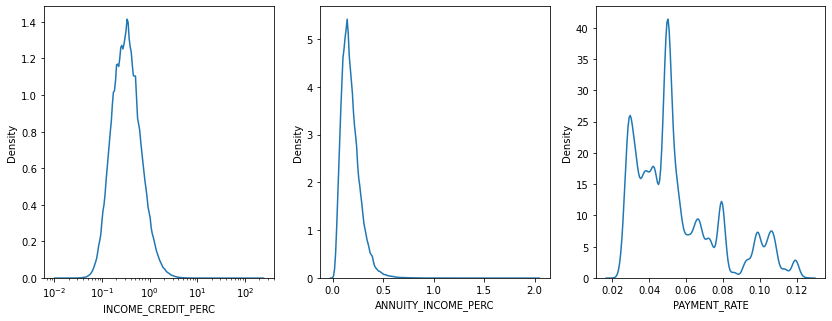

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,5))
sns.kdeplot(data['INCOME_CREDIT_PERC'], ax=ax1, log_scale=True) #df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
sns.kdeplot(data['ANNUITY_INCOME_PERC'], ax=ax2) #df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
sns.kdeplot(data['PAYMENT_RATE'], ax=ax3) #df['AMT_ANNUITY'] / df['AMT_CREDIT']
plt.show()

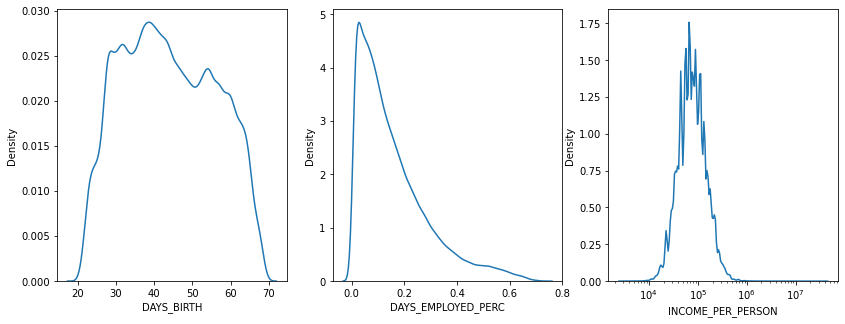

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,5))
sns.kdeplot(data['DAYS_BIRTH']/(-365), ax=ax1)
sns.kdeplot(data['DAYS_EMPLOYED_PERC'], ax=ax2)
sns.kdeplot(data['INCOME_PER_PERSON'], ax=ax3, log_scale=True)
plt.show()

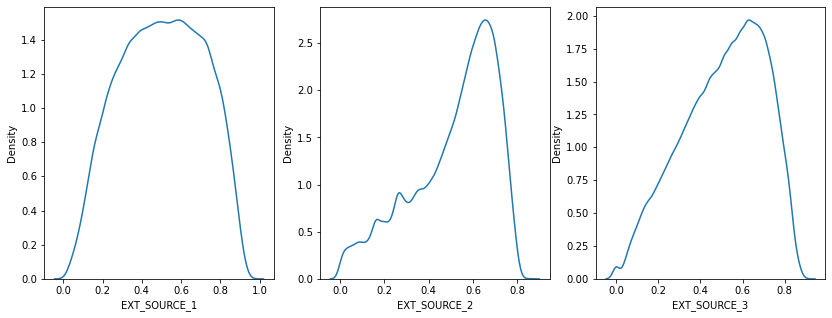

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,5))
sns.kdeplot(data['EXT_SOURCE_1'], ax=ax1)
sns.kdeplot(data['EXT_SOURCE_2'], ax=ax2)
sns.kdeplot(data['EXT_SOURCE_3'], ax=ax3)
plt.show()

# Modelisation

Generally, in tree-based models the scale of the features does not matter. This is because at each tree level, the score of a possible split will be equal whether the respective feature has been scaled or not.

In [32]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance",
                                                                                                   ascending=False)[
        :40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(
        cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(
        by="importance", ascending=False))
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.savefig('data/outputs/lgbm_importances01.png')

In [33]:
## Bayesian opt using Hyperopt
#from sklearn.ensemble import RandomForestClassifier 
#from sklearn import metrics
#from sklearn.model_selection import cross_val_score
#from sklearn.preprocessing import StandardScaler 
#from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
#from hyperopt.pyll.base import scope
#
## define parameter space
#space = {
#    "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
#    "max_depth": hp.quniform("max_depth", 1, 15,1),
#    "criterion": hp.choice("criterion", ["gini", "entropy"]),
#}
## define objective function
#def hyperparameter_tuning(params):
#    clf = RandomForestClassifier(**params,n_jobs=-1)
#    acc = cross_val_score(clf, X_train, y_train,scoring="roc_auc").mean()
#    return {"loss": -acc, "status": STATUS_OK}
## Fine tune the model
#trials = Trials()
#best = fmin(
#    fn=hyperparameter_tuning,
#    space = space, 
#    algo=tpe.suggest, 
#    max_evals=50, 
#    trials=trials
#)
#print("Best: {}".format(best))
##Best: {'criterion': 1, 'max_depth': 8.0, 'n_estimators': 4}

## Logistic Regression

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression


def logistic_reg(df, debug=False):

    if debug:
        df = df.sample(20000)

    # Correct columns name for Logistic Regression
    import re
    df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    X = train_df.drop(['TARGET'], axis=1)
    y = train_df['TARGET']
    sub_df = df[df['TARGET'].isnull()]
    

    # TRAIN /TEST
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    print("Starting Logistic Regression.\nTrain shape: {} (X_train: {}, X_test {})\nSubmission data shape: {}".format(
        train_df.shape, X_train.shape, X_test.shape, sub_df.shape))

    # Imputer
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    from sklearn.impute import SimpleImputer
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    X_train = pd.DataFrame(imp.fit_transform(X_train), columns = X_train.columns)
    
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    from sklearn.impute import SimpleImputer
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    X_test = pd.DataFrame(imp.fit_transform(X_test), columns = X_test.columns)
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))    
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
    
    #  Over sampling
    #from imblearn.over_sampling import SMOTE
    #smote = SMOTE()
    # fit predictor and target variable
    #X_train, y_train = smote.fit_resample(X_train, y_train)
    #print('Resample dataset shape', Counter(y))
    
    
    # summarize
    train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
    test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    del df
    gc.collect()

    # Balance dataset weights on train only (evaluation is done on unbalanced data https://datascience.stackexchange.com/questions/36285/what-is-the-best-performance-metric-used-in-balancing-dataset-using-smote-techni/36302#36302)
    #print(compute_sample_weight(class_weight='balanced', y=y_train))

    # Create arrays and dataframes to store results
    train_preds = np.zeros(X_train.shape[0])
    sub_preds = np.zeros(sub_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in [
        'TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    clf = LogisticRegression(class_weight='balanced', max_iter=1000)

    
    clf.fit(X_train[feats], y_train)

    y_pred = clf.predict(X_test[feats])
    y_pred_proba = clf.predict_proba(X_test[feats])[:,1]
    

    # view accuracy
    accuracy = accuracy_score(y_pred, y_test)
    print('Logistic Regression Model Test-set accuracy score: {0:0.4f}'.format(
        accuracy_score(y_test, y_pred)))

    # Compare train and test accuracy
    y_pred_train = clf.predict(X_train[feats])
    print(
        'Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Class: 0', 'Actual Class: 1'],
                             index=['Predict Class: 0', 'Predict Class: 1'])
    sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu',  #fmt='d'
               )
    
    # Classification metrics
    from sklearn.metrics import classification_report, fbeta_score
    from imblearn.metrics import classification_report_imbalanced
    print(classification_report_imbalanced(y_test, y_pred))
    print("F2 Score : {}".format(fbeta_score(y_train, y_pred_train, beta=2.0, average='weighted')))
    
    # ROC Curve
    print('Full AUC score %.6f' % roc_auc_score(y_test, y_pred))
    ns_probs = [0 for _ in range(len(y_test))]
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    clf_fpr, clf_tpr, _ = roc_curve(y_test, clf.predict_proba(X_test[feats])[:,1]) # plot the roc curve for the model
    plt.figure()
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(clf_fpr, clf_tpr, marker='.', label='Logistic Regression')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    display(X_train.shape, X_test.shape)


    return feature_importance_df, clf

Starting Logistic Regression.
Train shape: (307507, 791) (X_train: (246005, 790), X_test (61502, 790))
Submission data shape: (48744, 791)
>Train: 0=226145, 1=19860, Test: 0=56537, 1=4965


/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Model Test-set accuracy score: 0.4153
Training-set accuracy score: 0.7085
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.37      0.91      0.54      0.58      0.32     56537
        1.0       0.11      0.91      0.37      0.20      0.58      0.36      4965

avg / total       0.91      0.42      0.87      0.51      0.58      0.32     61502

F2 Score : 0.7234085940273087
Full AUC score 0.641393


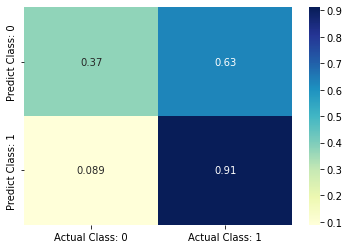

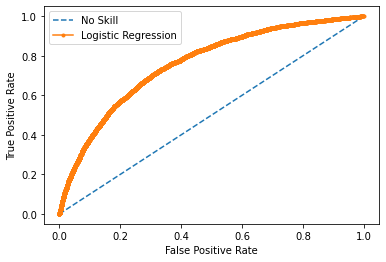

(246005, 790)

(61502, 790)

Run Logistic Regression - done in 291s


In [35]:
with timer("Run Logistic Regression"):
    feat_importance, model = logistic_reg(
        data, debug=False)

## RandomForest Classifier

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight


def randomforest(df, debug=False):

    if debug:
        df = df.sample(250000)

    # Correct columns name for RandomForest
    import re
    df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]  
    
       
    # Imputer
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    from sklearn.impute import SimpleImputer
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    train_df = pd.DataFrame(imp.fit_transform(train_df), columns = train_df.columns)
    
    X = train_df.drop(['TARGET'], axis=1)
    y = train_df['TARGET']
    sub_df = df[df['TARGET'].isnull()]
    
    sub_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # TRAIN /TEST
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    print("Starting RandomForest.\nTrain shape: {} (X_train: {}, X_test {})\nSubmission data shape: {}".format(
        train_df.shape, X_train.shape, X_test.shape, sub_df.shape))

    
    #  Over sampling
    #from imblearn.over_sampling import SMOTE
    #smote = SMOTE()
    # fit predictor and target variable
    #X_train, y_train = smote.fit_resample(X_train, y_train)
    #print('Resample dataset shape', Counter(y))
    
    
    # summarize
    train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
    test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    del df
    gc.collect()

    # Balance dataset weights on train only (evaluation is done on unbalanced data https://datascience.stackexchange.com/questions/36285/what-is-the-best-performance-metric-used-in-balancing-dataset-using-smote-techni/36302#36302)
    #print(compute_sample_weight(class_weight='balanced', y=y_train))

    # Create arrays and dataframes to store results
    train_preds = np.zeros(X_train.shape[0])
    sub_preds = np.zeros(sub_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in [
        'TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    
    # RandomForestClassifier parameters found by Bayesian optimization
    clf = RandomForestClassifier(criterion= 'gini',
                                 max_depth= 8.0,
                                 n_estimators= 4,
                                class_weight='balanced'
                                )

    
    clf.fit(X_train[feats], y_train #eval_set=[(X_train[feats], y_train),(X_test[feats], y_test)], eval_metric='auc',
            #,verbose=200, early_stopping_rounds=200
           )

    y_pred = clf.predict(X_test[feats])
    y_pred_proba = clf.predict_proba(X_test[feats])[:,1]
    sub_preds = clf.predict(pd.DataFrame(imp.fit_transform(sub_df[feats]), columns = sub_df[feats].columns))
    sub_preds_proba = clf.predict_proba(pd.DataFrame(imp.fit_transform(sub_df[feats]), columns = sub_df[feats].columns))[:,1]

    feature_importance_df["feature"] = feats
    feature_importance_df["importance"] = clf.feature_importances_
    most_important_features = [x for x in feature_importance_df.sort_values(
        by='importance', ascending=False).head(40)['feature']]
    most_important_features = ['SK_ID_CURR',
                               'TARGET', 'TARGET_1_PROBA'] + most_important_features

    # view accuracy
    accuracy = accuracy_score(y_pred, y_test)
    print('RandomForest Model Test-set accuracy score: {0:0.4f}'.format(
        accuracy_score(y_test, y_pred)))

    # Compare train and test accuracy
    y_pred_train = clf.predict(X_train[feats])
    print(
        'Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Class: 0', 'Actual Class: 1'],
                             index=['Predict Class: 0', 'Predict Class: 1'])
    sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu',  #fmt='d'
               )

    display(sub_preds_proba)
    
    # Classification metrics
    from sklearn.metrics import classification_report, fbeta_score
    from imblearn.metrics import classification_report_imbalanced
    print(classification_report_imbalanced(y_test, y_pred))
    print("F2 Score : {}".format(fbeta_score(y_train, y_pred_train, beta=2.0, average='weighted')))
    
    # ROC Curve
    print('Full AUC score %.6f' % roc_auc_score(y_test, y_pred))
    ns_probs = [0 for _ in range(len(y_test))]
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    clf_fpr, clf_tpr, _ = roc_curve(y_test, clf.predict_proba(X_test[feats])[:,1]) # plot the roc curve for the model
    plt.figure()
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(clf_fpr, clf_tpr, marker='.', label='RandomForest')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    display(X_train.shape, X_test.shape)

    
    display_importances(feature_importance_df)
    return feature_importance_df, clf, most_important_features

Starting RandomForest.
Train shape: (215947, 791) (X_train: (172757, 790), X_test (43190, 790))
Submission data shape: (34053, 791)
>Train: 0=158761, 1=13996, Test: 0=39691, 1=3499
RandomForest Model Test-set accuracy score: 0.6924
Training-set accuracy score: 0.7002


array([0.49571548, 0.40131979, 0.19515262, ..., 0.57311914, 0.56344098,
       0.22991602])

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.95      0.70      0.58      0.81      0.64      0.41     39691
        1.0       0.15      0.58      0.70      0.23      0.64      0.40      3499

avg / total       0.89      0.69      0.59      0.76      0.64      0.41     43190

F2 Score : 0.7163521820937455
Full AUC score 0.641897


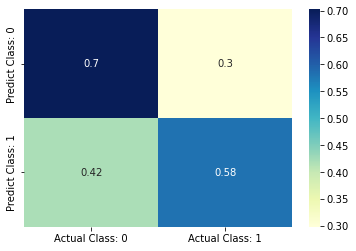

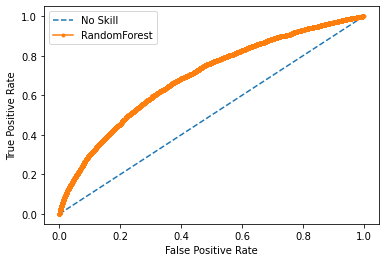

(172757, 790)

(43190, 790)

Run RandomForest - done in 69s


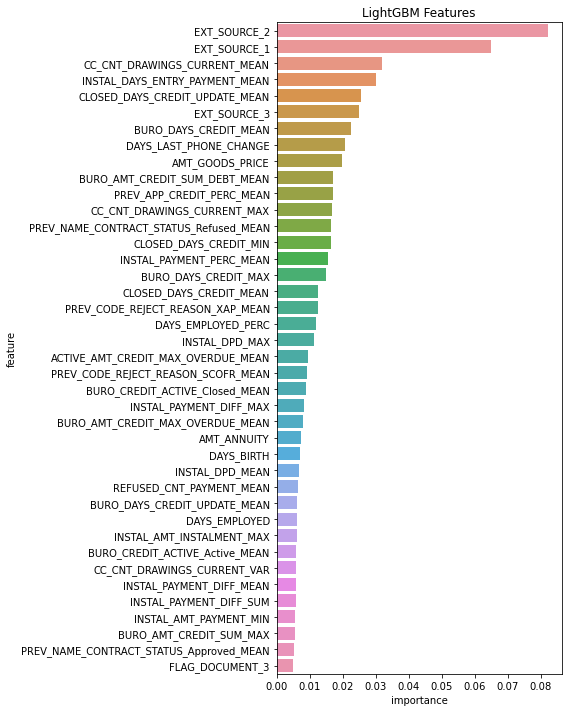

In [37]:
with timer("Run RandomForest"):
    feat_importance, model, most_important_features = randomforest(
        data, debug=True)

## LightGBM Classifier

- Quicker XGBoost
- Not sensible to missing data

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight


def lightgbm(df, debug=False):

    if debug:
        df = df.sample(20000)

    # Correct columns name for LightGBM
    import re
    df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    X = train_df.drop(['TARGET'], axis=1)
    y = train_df['TARGET']
    sub_df = df[df['TARGET'].isnull()]
    

    # TRAIN /TEST
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    print("Starting LightGBM.\nTrain shape: {} (X_train: {}, X_test {})\nSubmission data shape: {}".format(
        train_df.shape, X_train.shape, X_test.shape, sub_df.shape))

    # Imputer
    #X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    #from sklearn.impute import SimpleImputer
    #imp = SimpleImputer(missing_values=np.nan, strategy='median')
    #X_train = pd.DataFrame(imp.fit_transform(X_train), columns = X_train.columns)
    
    #  Over sampling
    #from imblearn.over_sampling import SMOTE
    #smote = SMOTE()
    # fit predictor and target variable
    #X_train, y_train = smote.fit_resample(X_train, y_train)
    #print('Resample dataset shape', Counter(y))
    
    
    # summarize
    train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
    test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    del df
    gc.collect()

    # Balance dataset weights on train only (evaluation is done on unbalanced data https://datascience.stackexchange.com/questions/36285/what-is-the-best-performance-metric-used-in-balancing-dataset-using-smote-techni/36302#36302)
    #print(compute_sample_weight(class_weight='balanced', y=y_train))

    # Create arrays and dataframes to store results
    train_preds = np.zeros(X_train.shape[0])
    sub_preds = np.zeros(sub_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in [
        'TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
        nthread=4,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=34,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.0222415,
        min_child_weight=39.3259775,
        first_metric_only=True,
        class_weight='balanced'
        #is_unbalance=True
        )

    
    clf.fit(X_train[feats], y_train, eval_set=[(X_train[feats], y_train),
            (X_test[feats], y_test)], eval_metric='auc', verbose=200, early_stopping_rounds=200)

    y_pred = clf.predict(X_test[feats])
    y_pred_proba = clf.predict_proba(X_test[feats])[:,1]
    sub_preds = clf.predict(sub_df[feats])
    sub_preds_proba = clf.predict_proba(sub_df[feats])[:,1]

    feature_importance_df["feature"] = feats
    feature_importance_df["importance"] = clf.feature_importances_
    most_important_features = [x for x in feature_importance_df.sort_values(
        by='importance', ascending=False).head(50)['feature']]
    most_important_features = ['SK_ID_CURR',
                               'TARGET', 'TARGET_1_PROBA'] + most_important_features

    # view accuracy
    accuracy = accuracy_score(y_pred, y_test)
    print('LightGBM Model Test-set accuracy score: {0:0.4f}'.format(
        accuracy_score(y_test, y_pred)))

    # Compare train and test accuracy
    y_pred_train = clf.predict(X_train[feats])
    print(
        'Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Class: 0', 'Actual Class: 1'],
                             index=['Predict Class: 0', 'Predict Class: 1'])
    sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu',  #fmt='d'
               )

    display(sub_preds_proba)
    
    # Classification metrics
    from sklearn.metrics import classification_report, fbeta_score
    from imblearn.metrics import classification_report_imbalanced
    print(classification_report_imbalanced(y_test, y_pred))
    print("F2 Score : {}".format(fbeta_score(y_train, y_pred_train, beta=2.0, average='weighted')))
    
    # ROC Curve
    print('Full AUC score %.6f' % roc_auc_score(y_test, y_pred))
    ns_probs = [0 for _ in range(len(y_test))]
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    clf_fpr, clf_tpr, _ = roc_curve(y_test, clf.predict_proba(X_test[feats])[:,1]) # plot the roc curve for the model
    plt.figure()
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(clf_fpr, clf_tpr, marker='.', label='LGBM')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    display(X_train.shape, X_test.shape)


    # Write submission file and plot feature importance
    if not debug:
        sub_df['TARGET'] = sub_preds
        sub_df['TARGET_1_PROBA'] = sub_preds_proba
        sub_df[['SK_ID_CURR', 'TARGET', 'TARGET_1_PROBA']].to_csv(
            'data/outputs/sub_df_short.csv', index=False)
        sub_df.to_csv(
            'data/outputs/sub_df_full_predicted.csv', index=False)
        sub_df[most_important_features].to_csv('data/outputs/sub_df_full_most_important_feat.csv', index=False)
    display_importances(feature_importance_df)
    return feature_importance_df, clf, most_important_features

Starting LightGBM.
Train shape: (307507, 791) (X_train: (246005, 790), X_test (61502, 790))
Submission data shape: (48744, 791)
>Train: 0=226145, 1=19860, Test: 0=56537, 1=4965


/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	valid_0's auc: 0.800699	valid_0's binary_logloss: 0.555598	valid_1's auc: 0.776029	valid_1's binary_logloss: 0.560537
[400]	valid_0's auc: 0.826986	valid_0's binary_logloss: 0.525412	valid_1's auc: 0.785655	valid_1's binary_logloss: 0.535947
[600]	valid_0's auc: 0.84517	valid_0's binary_logloss: 0.506007	valid_1's auc: 0.788821	valid_1's binary_logloss: 0.521373
[800]	valid_0's auc: 0.860279	valid_0's binary_logloss: 0.489989	valid_1's auc: 0.789792	valid_1's binary_logloss: 0.509944
[1000]	valid_0's auc: 0.873245	valid_0's binary_logloss: 0.475813	valid_1's auc: 0.789948	valid_1's binary_logloss: 0.500224
[1200]	valid_0's auc: 0.885093	valid_0's binary_logloss: 0.462333	valid_1's auc: 0.790005	valid_1's binary_logloss: 0.49112
LightGBM Model Test-set accuracy score: 0.7611
Training-set accuracy score: 0.7847


array([0.34670577, 0.58999536, 0.19220193, ..., 0.05154766, 0.23745036,
       0.77291809])

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.77      0.66      0.86      0.71      0.52     56537
        1.0       0.20      0.66      0.77      0.31      0.71      0.50      4965

avg / total       0.90      0.76      0.67      0.81      0.71      0.51     61502

F2 Score : 0.7940785429854186
Full AUC score 0.715850


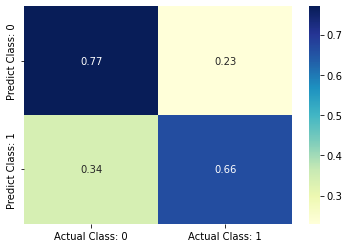

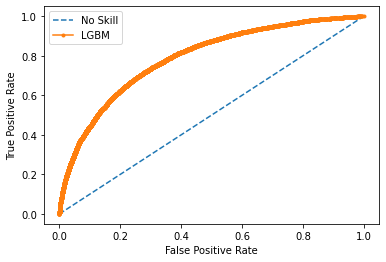

(246005, 790)

(61502, 790)

Run LightGBM - done in 235s


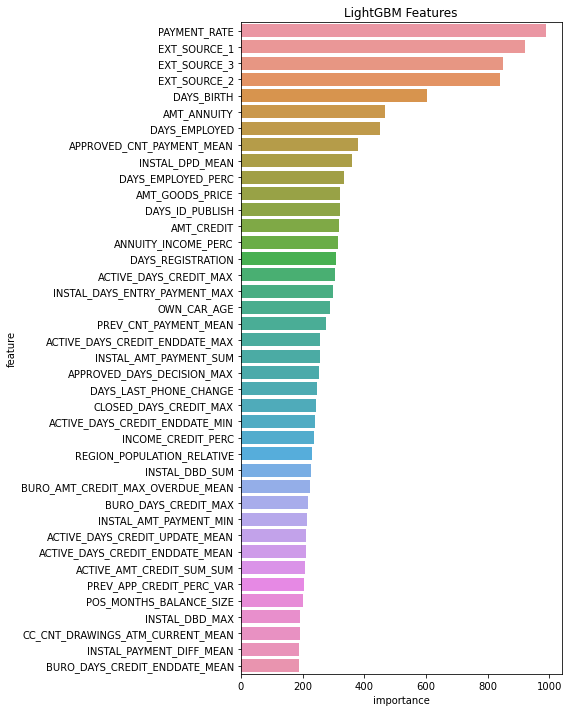

In [39]:
with timer("Run LightGBM"):
    feat_importance, initial_model, most_important_features = lightgbm(
        data, debug=False)

pickle.dump(initial_model, open('pickles/initial_model.pkl', 'wb'))

# Features Selection and final export
In order to reduce the number of features for further Dashboard, we select 40 most important features according to the model.

In [40]:
#model = pickle.load(open('pickles/final_model.pkl', 'rb'))

In [70]:
data_filtered = pd.read_csv('data/outputs/sub_df_full_most_important_feat.csv')
df_1 = data[data['TARGET'].notnull()]
df_1['TARGET_1_PROBA'] = df_1['TARGET']
df_1[most_important_features]
data_final = df_1[most_important_features].append(data_filtered)

data_final.sort_values(by='SK_ID_CURR').head(5000).to_csv('data/outputs/data_final.csv', index=False)

In [71]:
data_final[data_final['SK_ID_CURR'] == 100001]

,SK_ID_CURR,TARGET,TARGET_1_PROBA,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,INSTAL_AMT_PAYMENT_SUM,AMT_ANNUITY,DAYS_EMPLOYED,CLOSED_AMT_CREDIT_SUM_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,PREV_APP_CREDIT_PERC_VAR,AMT_GOODS_PRICE,DAYS_EMPLOYED_PERC,PREV_APP_CREDIT_PERC_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_DPD_MEAN,REGION_POPULATION_RELATIVE,ANNUITY_INCOME_PERC,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,DAYS_REGISTRATION,APPROVED_CNT_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MAX,PREV_CNT_PAYMENT_MEAN,INSTAL_PAYMENT_DIFF_MEAN,ACTIVE_DAYS_CREDIT_MAX,DAYS_ID_PUBLISH,PREV_DAYS_DECISION_MAX,ACTIVE_AMT_CREDIT_SUM_MEAN,CLOSED_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_MAX,AMT_CREDIT,PREV_APP_CREDIT_PERC_MIN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MEAN,DAYS_LAST_PHONE_CHANGE,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,INSTAL_DBD_SUM,OWN_CAR_AGE,INSTAL_DBD_MEAN,INSTAL_DBD_MAX,POS_MONTHS_BALANCE_SIZE,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,INCOME_CREDIT_PERC,BURO_DAYS_CREDIT_ENDDATE_MAX,CODE_GENDER
0,100001,0.0,0.320186,0.036147,0.752614,0.15952,0.789654,-19241,41195.925,20560.5,-2329.0,142335.0,-1628.0,NaN,450000.0,0.121044,1.044079,884025.0,3951.0,-15365.0,1.571429,0.01885,0.1523,NaN,-5170.0,8.0,-1740.0,8.0,0.0,-49.0,-812,-1740.0,294675.0,-857.0,411.0,-179.0,-49.0,568800.0,1.044079,-10.666667,82.428571,-1740.0,NaN,1778.0,62.0,NaN,8.857143,36.0,9.0,1030.333333,0.237342,1778.0,1


Starting LightGBM.
Train shape: (307507, 52) (X_train: (246005, 51), X_test (61502, 51))
Submission data shape: (48744, 52)
>Train: 0=226145, 1=19860, Test: 0=56537, 1=4965


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	valid_0's auc: 0.792221	valid_0's binary_logloss: 0.56191	valid_1's auc: 0.770245	valid_1's binary_logloss: 0.566144
[400]	valid_0's auc: 0.815312	valid_0's binary_logloss: 0.536021	valid_1's auc: 0.779499	valid_1's binary_logloss: 0.544588
[600]	valid_0's auc: 0.830955	valid_0's binary_logloss: 0.520108	valid_1's auc: 0.781966	valid_1's binary_logloss: 0.532838
[800]	valid_0's auc: 0.843928	valid_0's binary_logloss: 0.507083	valid_1's auc: 0.782787	valid_1's binary_logloss: 0.523772
[1000]	valid_0's auc: 0.855553	valid_0's binary_logloss: 0.495153	valid_1's auc: 0.783482	valid_1's binary_logloss: 0.51544
[1200]	valid_0's auc: 0.865874	valid_0's binary_logloss: 0.484196	valid_1's auc: 0.783372	valid_1's binary_logloss: 0.507935
LightGBM Model Test-set accuracy score: 0.7456
Training-set accuracy score: 0.7642


array([0.31060753, 0.41991567, 0.21749237, ..., 0.11874669, 0.35903189,
       0.78794569])

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.75      0.67      0.84      0.71      0.51     56537
        1.0       0.19      0.67      0.75      0.30      0.71      0.50      4965

avg / total       0.90      0.75      0.67      0.80      0.71      0.51     61502

F2 Score : 0.775006751582236
Full AUC score 0.709867


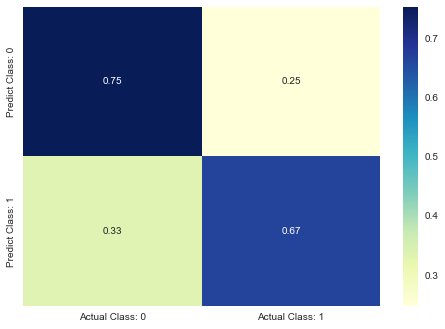

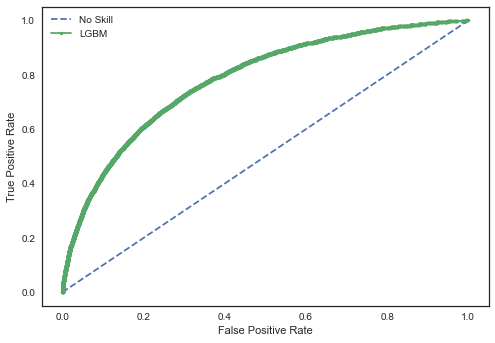

(246005, 51)

(61502, 51)

Run LightGBM - done in 51s


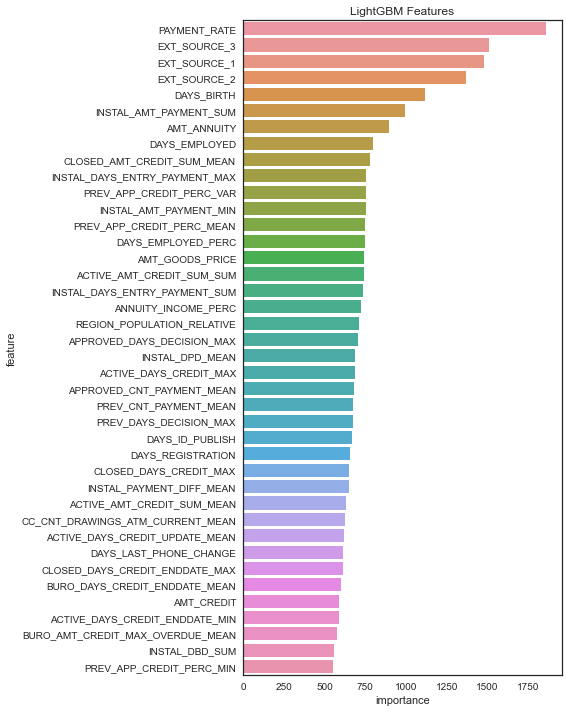

In [72]:
with timer("Run LightGBM"):
    feat_importance, model, most_important_features = lightgbm(
        data[[x for x in most_important_features if x !='TARGET_1_PROBA']], debug=False)

pickle.dump(model, open('pickles/final_model.pkl', 'wb'))

# Interprétation LIME

In [76]:
# Imputer
data_final.replace([np.inf, -np.inf], np.nan, inplace=True)
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')
data_final = pd.DataFrame(imp.fit_transform(data_final), columns = data_final.columns)

In [77]:
import lime.lime_tabular
# distinct classes from the target variable
class_names = ['0: Low Risk', '1: Failure Risk']

# create explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(training_data=data_final.drop([
    'TARGET', 'SK_ID_CURR', 'TARGET_1_PROBA'], axis=1).values,  # Needs to be in Numpy array format
    mode='classification',
    training_labels=data_final['TARGET'],
    feature_names=data_final.drop([
        'TARGET', 'SK_ID_CURR', 'TARGET_1_PROBA'], axis=1).columns,
    class_names=class_names,
    discretize_continuous=False)

In [78]:
explanation = explainer_lime.explain_instance(data_final.drop([
    'TARGET', 'SK_ID_CURR', 'TARGET_1_PROBA'], axis=1).loc[50].values,
    model.predict_proba,
    num_features=data_final.drop(
        ['TARGET', 'SK_ID_CURR', 'TARGET_1_PROBA'], axis=1).shape[1]
)

In [79]:
explanation.show_in_notebook(predict_proba=True,
                             show_predicted_value=True,
                             show_table=True,
                             show_all=False)

Text(0.5, 1.0, 'Local explanation for class 1: Credit Default')

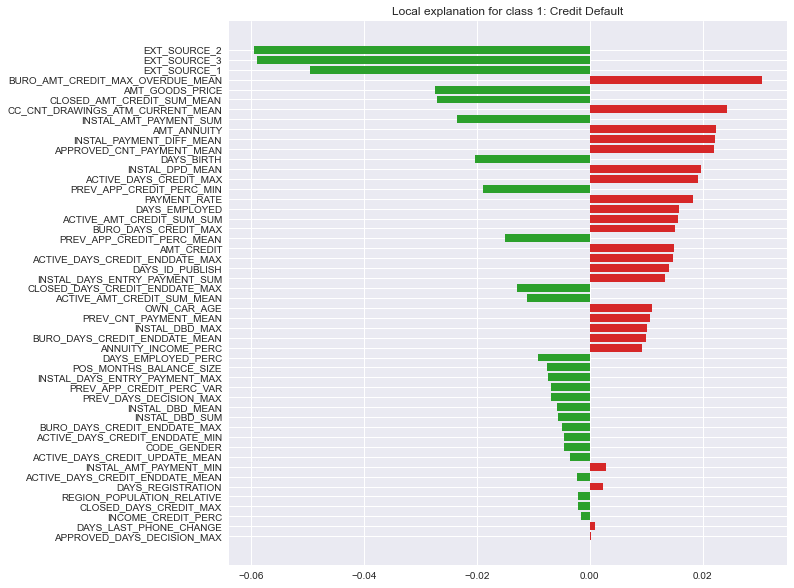

In [80]:
exp = explanation.as_list()

vals = [x[1] for x in exp]
names = [x[0] for x in exp]

vals.reverse()
names.reverse()
pos = np.arange(len(vals))

plt.figure(figsize=(10, 10))
plt.style.use('seaborn')
colors = ['tab:red' if x > 0 else 'tab:green' for x in vals]

plt.barh(pos, vals, align='center', color=colors)
plt.yticks(pos, names)
plt.title('Local explanation for class 1: Credit Default')

# Interprétation SHAP

In [47]:
import shap
explainer_shap = shap.TreeExplainer(model=model, data=data_final.drop([
        'TARGET', 'SK_ID_CURR','TARGET_1_PROBA'], axis=1).values)

In [48]:
#shap_values = explainer_shap.shap_values(data_final.drop([
#        'TARGET', 'SK_ID_CURR', 'TARGET_1_PROBA'], axis=1).values, check_additivity=False)
#pickle.dump(shap_values, open('pickles/shap_values.pkl', 'wb'))
shap_values = pickle.load(open('pickles/shap_values.pkl', 'rb'))

In [49]:
shap.initjs()

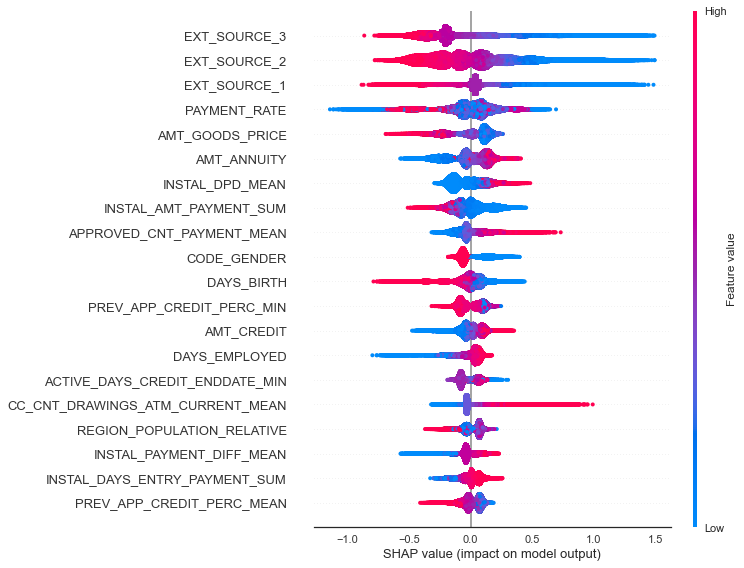

In [50]:
plt.style.use('seaborn-white')

shap.summary_plot(shap_values, data_final.drop([
        'TARGET', 'SK_ID_CURR', 'TARGET_1_PROBA'], axis=1).values, feature_names=data_final.drop([
        'TARGET', 'SK_ID_CURR', 'TARGET_1_PROBA'], axis=1).columns)

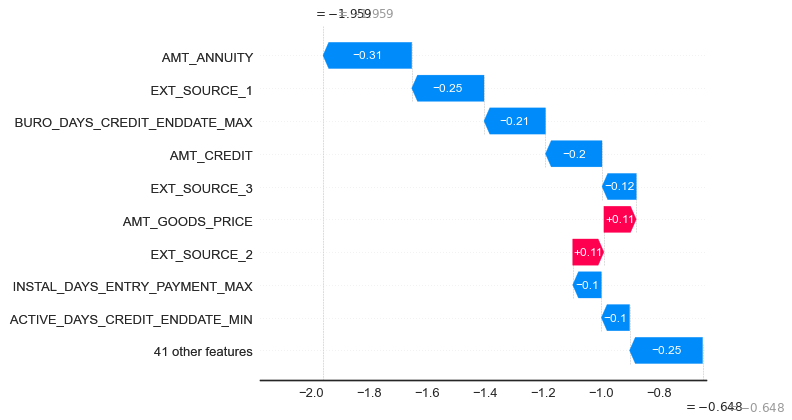

TARGET = 0.0
TARGET PROBA = 0.0


In [51]:
def shap_waterfall(i):
    shap.plots._waterfall.waterfall_legacy(
        explainer_shap.expected_value, shap_values[i], data_final.drop([
            'TARGET', 'SK_ID_CURR', 'TARGET_1_PROBA'], axis=1).iloc[i], feature_names=data_final.drop([
            'TARGET', 'SK_ID_CURR', 'TARGET_1_PROBA'], axis=1).columns)
    print('TARGET = {}\nTARGET PROBA = {}'.format(data_final.TARGET.iloc[i], data_final.TARGET_1_PROBA.iloc[i]))
    
shap_waterfall(50)

# Client Neighbors

In [52]:
data_final.drop('SK_ID_CURR', axis=1).iloc[50]

TARGET                                   0.000000
TARGET_1_PROBA                           0.000000
PAYMENT_RATE                             0.050000
EXT_SOURCE_1                             0.656225
EXT_SOURCE_3                             0.479449
EXT_SOURCE_2                             0.450850
DAYS_BIRTH                          -12406.000000
AMT_ANNUITY                           6750.000000
DAYS_EMPLOYED                        -1176.000000
APPROVED_CNT_PAYMENT_MEAN               12.000000
INSTAL_DPD_MEAN                          0.035714
DAYS_EMPLOYED_PERC                       0.094793
AMT_GOODS_PRICE                     135000.000000
DAYS_ID_PUBLISH                      -2576.000000
AMT_CREDIT                          135000.000000
ANNUITY_INCOME_PERC                      0.125000
DAYS_REGISTRATION                    -1149.000000
ACTIVE_DAYS_CREDIT_MAX                -223.000000
INSTAL_DAYS_ENTRY_PAYMENT_MAX          -65.000000
OWN_CAR_AGE                              9.000000


In [53]:
def neighbors(i, n_neighbors):
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(data_final.drop('SK_ID_CURR', axis=1))
    neighbors_idx = nbrs.kneighbors(data_final.drop('SK_ID_CURR', axis=1).iloc[[i]], n_neighbors=n_neighbors+1, return_distance=False)
    neighbors_mean = pd.DataFrame(data_final.iloc[neighbors_idx[0]].mean(axis=0)).T
    comparison = pd.DataFrame(data_final.iloc[i]).T.append(neighbors_mean).reset_index(drop=True)
    comparison.rename(index={0:'Client',1:'Neighbors Mean'}, inplace=True)
    
    display(data_final.iloc[neighbors_idx[0]])
    display(comparison)
    
neighbors(50, n_neighbors=15)

,SK_ID_CURR,TARGET,TARGET_1_PROBA,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,APPROVED_CNT_PAYMENT_MEAN,INSTAL_DPD_MEAN,DAYS_EMPLOYED_PERC,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,AMT_CREDIT,ANNUITY_INCOME_PERC,DAYS_REGISTRATION,ACTIVE_DAYS_CREDIT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MAX,OWN_CAR_AGE,PREV_CNT_PAYMENT_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,INSTAL_AMT_PAYMENT_SUM,APPROVED_DAYS_DECISION_MAX,DAYS_LAST_PHONE_CHANGE,CLOSED_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,INCOME_CREDIT_PERC,REGION_POPULATION_RELATIVE,INSTAL_DBD_SUM,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_DAYS_CREDIT_MAX,INSTAL_AMT_PAYMENT_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,PREV_APP_CREDIT_PERC_VAR,POS_MONTHS_BALANCE_SIZE,INSTAL_DBD_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,INSTAL_PAYMENT_DIFF_MEAN,BURO_DAYS_CREDIT_ENDDATE_MEAN,CLOSED_AMT_CREDIT_SUM_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,CODE_GENDER,CLOSED_DAYS_CREDIT_ENDDATE_MAX,INSTAL_DBD_MEAN,PREV_APP_CREDIT_PERC_MIN,ACTIVE_AMT_CREDIT_SUM_MEAN,BURO_DAYS_CREDIT_ENDDATE_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_DAYS_DECISION_MAX
50,100058.0,0.0,0.000000,0.050000,0.656225,0.479449,0.450850,-12406.0,6750.0,-1176.0,12.0,0.035714,0.094793,135000.0,-2576.0,135000.0,0.125000,-1149.0,-223.0,-65.0,9.0,12.000000,31087.0,324801.225,-438.0,0.0,-650.0,284.0,0.400000,0.014520,267.0,0.0000,-223.0,2323.575,15685.5,-18.000000,270000.000,0.009790,22.0,31.0,0.260137,0.000000,7571.000000,270000.000000,-21233.0,1.0,-378.0,10.125000,0.898449,135000.000,31087.0,0.971373,-304.0
211844,345500.0,0.0,0.000000,0.038000,0.506155,0.367291,0.239152,-19883.0,5130.0,-1663.0,12.0,0.035714,0.120073,135000.0,-2861.0,135000.0,0.076000,-8222.0,-745.0,-65.0,9.0,12.000000,351.0,324801.225,-438.0,-2.0,-780.0,-772.0,0.500000,0.018209,267.0,18080.0550,-745.0,2323.575,-210.5,-217.500000,289350.000,0.009790,22.0,31.0,0.260137,0.000000,-278.666667,210001.500000,-21233.0,1.0,-415.0,10.125000,0.898449,144675.000,351.0,0.971373,-304.0
267534,409962.0,0.0,0.000000,0.049557,0.506155,0.657784,0.207295,-19962.0,7047.0,-1189.0,20.0,0.000000,0.059563,112500.0,-1352.0,142200.0,0.078300,-10705.0,-372.0,-9.0,9.0,15.000000,31074.0,373832.460,-187.0,-187.0,-933.0,726.0,0.632911,0.019101,83.0,0.0000,-372.0,14367.240,15900.0,-10.500000,309866.400,0.897837,18.0,13.0,0.260137,0.000000,7841.000000,232006.500000,-4271.0,1.0,-203.0,4.882353,0.737880,154933.200,31074.0,1.337784,-187.0
176843,304929.0,0.0,0.000000,0.070458,0.506155,0.768808,0.480298,-21811.0,10453.5,-1663.0,24.0,0.000000,0.120073,135000.0,-4750.0,148365.0,0.105591,-7286.0,-152.0,-198.0,9.0,24.000000,9817.0,252200.070,-676.0,-676.0,-507.0,579.0,0.667273,0.007020,145.0,0.0000,-152.0,10825.740,5198.0,-574.000000,279000.000,0.009790,17.0,19.0,0.260137,0.000000,644.875000,264779.250000,-6849.0,1.0,103.0,9.062500,1.000000,139500.000,9817.0,1.000000,-333.0
122880,242474.0,0.0,0.000000,0.092520,0.506155,0.256706,0.090401,-21984.0,10408.5,-1663.0,12.0,0.035714,0.120073,112500.0,-4059.0,112500.0,0.154200,-7037.0,-384.0,-65.0,9.0,12.000000,72.0,324801.225,-438.0,-2.0,-1110.0,-19.0,0.600000,0.018209,267.0,364.9050,-384.0,2323.575,26.5,-16.000000,211604.940,0.009790,22.0,31.0,0.260137,0.000000,-278.250000,238992.750000,-21233.0,1.0,-355.0,10.125000,0.898449,105802.470,72.0,0.971373,-304.0
245259,383854.0,0.0,0.000000,0.108943,0.506155,0.574447,0.049321,-13344.0,11358.0,-788.0,11.5,0.982759,0.059053,90000.0,-5345.0,104256.0,0.100960,-5342.0,-329.0,-12.0,13.0,11.500000,1497.0,372583.935,-547.0,0.0,-1161.0,613.0,1.079075,0.010966,532.0,0.0000,-329.0,269.820,1055.0,-62.000000,256500.000,0.009446,49.0,33.0,0.260137,2235.441724,-979.400000,225854.260000,-41897.0,1.0,-585.0,9.172414,0.783962,128250.000,1497.0,0.856817,-546.0
300960,448670.0,0.0,0.000000,0.065801,0.506155,0.562060,0.593894,-17322.0,12402.0,-752.0,21.0,2.238095,0.043413,166500.0,-872.0,188478.0,0.137800,-5792.0,-728.0,-43.0,9.0,24.000000,616.0,331034.265,-537.0,-1191.0,-1149.0,616.0,0.477509,0

,SK_ID_CURR,TARGET,TARGET_1_PROBA,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,APPROVED_CNT_PAYMENT_MEAN,INSTAL_DPD_MEAN,DAYS_EMPLOYED_PERC,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,AMT_CREDIT,ANNUITY_INCOME_PERC,DAYS_REGISTRATION,ACTIVE_DAYS_CREDIT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MAX,OWN_CAR_AGE,PREV_CNT_PAYMENT_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,INSTAL_AMT_PAYMENT_SUM,APPROVED_DAYS_DECISION_MAX,DAYS_LAST_PHONE_CHANGE,CLOSED_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,INCOME_CREDIT_PERC,REGION_POPULATION_RELATIVE,INSTAL_DBD_SUM,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_DAYS_CREDIT_MAX,INSTAL_AMT_PAYMENT_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,PREV_APP_CREDIT_PERC_VAR,POS_MONTHS_BALANCE_SIZE,INSTAL_DBD_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,INSTAL_PAYMENT_DIFF_MEAN,BURO_DAYS_CREDIT_ENDDATE_MEAN,CLOSED_AMT_CREDIT_SUM_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,CODE_GENDER,CLOSED_DAYS_CREDIT_ENDDATE_MAX,INSTAL_DBD_MEAN,PREV_APP_CREDIT_PERC_MIN,ACTIVE_AMT_CREDIT_SUM_MEAN,BURO_DAYS_CREDIT_ENDDATE_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_DAYS_DECISION_MAX
Client,100058.0000,0.000,0.000000,0.050000,0.656225,0.479449,0.450850,-12406.000,6750.0000,-1176.0000,12.00000,0.035714,0.094793,135000.0,-2576.0000,135000.00000,0.125000,-1149.000,-223.0000,-65.0,9.00,12.000000,31087.0000,324801.225000,-438.0000,0.000,-650.0,284.0000,0.400000,0.014520,267.0,0.000000,-223.000,2323.575,15685.5000,-18.000000,270000.000000,0.009790,22.0000,31.000,0.260137,0.000000,7571.000000,270000.000000,-21233.0000,1.0000,-378.0000,10.125000,0.898449,135000.000000,31087.00,0.971373,-304.0000
Neighbors Mean,290283.0625,0.125,0.095608,0.075996,0.491813,0.553276,0.418024,-17332.125,10787.0625,-1904.5625,13.06875,0.286306,0.111180,135000.0,-3336.1875,141895.96875,0.103191,-5201.625,-312.3125,-63.5,9.25,14.772917,9225.5625,329746.831875,-391.6875,-752.625,-815.0,786.4375,0.923038,0.014333,287.5,2837.812969,-283.875,2974.725,4778.3125,-129.614583,268723.560937,0.062931,24.5625,29.625,0.321210,216.778448,1230.458185,236173.665502,-17539.5625,0.5625,-108.6875,9.701053,0.872806,135789.047813,9236.75,0.966889,-328.3125


In [54]:
data_final

,SK_ID_CURR,TARGET,TARGET_1_PROBA,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,APPROVED_CNT_PAYMENT_MEAN,INSTAL_DPD_MEAN,DAYS_EMPLOYED_PERC,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,AMT_CREDIT,ANNUITY_INCOME_PERC,DAYS_REGISTRATION,ACTIVE_DAYS_CREDIT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MAX,OWN_CAR_AGE,PREV_CNT_PAYMENT_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,INSTAL_AMT_PAYMENT_SUM,APPROVED_DAYS_DECISION_MAX,DAYS_LAST_PHONE_CHANGE,CLOSED_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,INCOME_CREDIT_PERC,REGION_POPULATION_RELATIVE,INSTAL_DBD_SUM,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_DAYS_CREDIT_MAX,INSTAL_AMT_PAYMENT_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,PREV_APP_CREDIT_PERC_VAR,POS_MONTHS_BALANCE_SIZE,INSTAL_DBD_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,INSTAL_PAYMENT_DIFF_MEAN,BURO_DAYS_CREDIT_ENDDATE_MEAN,CLOSED_AMT_CREDIT_SUM_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,CODE_GENDER,CLOSED_DAYS_CREDIT_ENDDATE_MAX,INSTAL_DBD_MEAN,PREV_APP_CREDIT_PERC_MIN,ACTIVE_AMT_CREDIT_SUM_MEAN,BURO_DAYS_CREDIT_ENDDATE_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_DAYS_DECISION_MAX
0,100002.0,1.0,1.000000,0.060749,0.083037,0.139376,0.262949,-9461.0,24700.5,-637.0,24.000000,0.000000,0.067329,351000.0,-2120.0,406597.5,0.121978,-3648.0,-103.0,-49.0,9.0,24.000000,780.0,219625.695,-606.0,-1134.0,-476.0,780.0,0.498036,0.018801,388.0,1681.029,-103.0,9251.775,780.0,-15.5,481988.565,0.009790,19.0,31.0,0.260137,0.000000,-349.000000,63844.500000,-5993.0,0.0,85.0,20.421053,1.000000,2.409943e+05,780.0,1.000000,-606.0
1,100003.0,0.0,0.000000,0.027598,0.311267,0.533482,0.622246,-16765.0,35698.5,-1188.0,10.000000,0.000000,0.070862,1129500.0,-291.0,1293502.5,0.132217,-1186.0,-606.0,-544.0,9.0,10.000000,1216.0,1618864.650,-746.0,-828.0,-775.0,1216.0,0.208736,0.003541,179.0,0.000,-606.0,6662.970,1216.0,-43.0,810000.000,0.005324,28.0,14.0,0.260137,0.000000,-544.500000,69133.500000,-34633.0,1.0,-420.0,7.160000,0.868825,8.100000e+05,1216.0,0.949329,-746.0
2,100004.0,0.0,0.000000,0.050000,0.506155,0.729567,0.555912,-19046.0,6750.0,-225.0,4.000000,0.000000,0.011814,135000.0,-2531.0,135000.0,0.100000,-4260.0,-264.0,-727.0,26.0,4.000000,1057.0,21288.465,-815.0,-815.0,-408.0,257.0,0.500000,0.010032,23.0,0.000,-408.0,5357.250,724.0,-30.0,660604.500,0.009790,4.0,11.0,0.260137,0.000000,-488.500000,94518.900000,-2285.0,0.0,-382.0,7.666667,1.207699,2.790000e+05,-382.0,1.207699,-815.0
3,100006.0,0.0,0.000000,0.094941,0.506155,0.533482,0.650442,-19005.0,29686.5,-3039.0,18.000000,0.000000,0.159905,297000.0,-2437.0,312682.5,0.219900,-9833.0,-264.0,-12.0,9.0,23.000000,1057.0,1007153.415,-181.0,-617.0,-727.0,257.0,0.431748,0.008019,310.0,0.000,-305.0,2482.920,724.0,-30.0,660604.500,0.027041,21.0,77.0,0.260137,0.000000,-131.788889,126188.910000,-4346.0,1.0,-207.0,19.375000,0.759418,2.790000e+05,912.0,1.010763,-181.0
4,100007.0,0.0,0.000000,0.042623,0.506155,0.533482,0.322738,-19932.0,21865.5,-3038.0,20.666667,0.954545,0.152418,513000.0,-3458.0,513000.0,0.179963,-4311.0,-264.0,-14.0,9.0,20.666667,1057.0,806127.975,-374.0,-1106.0,-1149.0,257.0,0.236842,0.028663,303.0,0.000,-1149.0,0.180,724.0,-30.0,660604.500,0.016456,66.0,31.0,0.260137,452.384318,-783.000000,146250.000000,-68128.0,0.0,-783.0,4.590909,0.791139,2.790000e+05,-783.0,0.969650,-374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,456221.0,0.0,0.308788,0.042354,0.506155,0.643026,0.648575,-19970.0,17473.5,-5169.0,24.000000,0.000000,0.258838,270000.0,-3399.0,412560.0,0.143815,-9094.0,-303.0,-599.0,9.0,24.000000,793.0,273109.365,-683.0,-684.0,-113.0,495.0,0.294503,0.002042,22.0,11427.750,-113.0,14222.430,644.0,-27.5,837931.500,0.009790,4.0,8.0,0.260137,0.000000,7.000000,93622.500000,-1891.0,1.0,-98.0,7.333333,0.883392,4.189658e+05,793.0,0.883392,-683.0
356247,456222.0,0.0,0.425889,0.051267,0.506155,0.